In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# For data vasualisation, source: https://www.kaggle.com/code/alexisbcook/hello-seaborn
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/ODET_PA.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/BOL_PA.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/UMG_AMS.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/VIV_PA.json


In [2]:
# Load the JSON data from the file
with open('/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/BOL_PA.json') as json_file:
    data = json.load(json_file)

bollore_data = data["Time Series (Daily)"]

df = pd.DataFrame(bollore_data)
df = df.transpose()



print(df)

            1. open  2. high   3. low 4. close 5. volume
2024-01-26   5.9250   6.0200   5.9200   5.9700    701693
2024-01-25   5.8500   5.9650   5.8500   5.9000    950562
2024-01-24   5.7200   5.8500   5.7200   5.8400    634590
2024-01-23   5.7750   5.7750   5.7000   5.7000    515673
2024-01-22   5.6550   5.7650   5.6550   5.7600    550502
...             ...      ...      ...      ...       ...
2005-01-07  59.1000  59.2000  58.8000  58.8000   1172700
2005-01-06  58.8500  59.5000  58.6500  59.0000    372900
2005-01-05  59.4500  59.4500  58.6500  59.0000    407500
2005-01-04  59.4000  59.9000  59.4000  59.5000   1711700
2005-01-03  60.4500  60.4500  59.4500  59.5000    123100

[4884 rows x 5 columns]


In [3]:
# Function to load data and reformat it as a pandas df
# Uses only data from '2021-09-21' - (UMG IPO) 

def load_timeseries_as_df(ticker="BOL_PA"):
    with open(f'/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/{ticker}.json') as json_file:
        data = json.load(json_file)

    timeseries_data = data["Time Series (Daily)"]

    df = pd.DataFrame(timeseries_data)
    df = df.transpose()
    
    # filter dates to relevant timeperiod
    df.index = pd.to_datetime(df.index)
    start_date = pd.to_datetime('2021-09-21')
    df = df[df.index >= start_date]

    return df   

In [4]:
bol_df = load_timeseries_as_df(ticker="BOL_PA")
odet_df = load_timeseries_as_df(ticker="ODET_PA")
umg_df = load_timeseries_as_df(ticker="UMG_AMS")
viv_df = load_timeseries_as_df(ticker="VIV_PA")

print(bol_df)

           1. open 2. high  3. low 4. close 5. volume
2024-01-26  5.9250  6.0200  5.9200   5.9700    701693
2024-01-25  5.8500  5.9650  5.8500   5.9000    950562
2024-01-24  5.7200  5.8500  5.7200   5.8400    634590
2024-01-23  5.7750  5.7750  5.7000   5.7000    515673
2024-01-22  5.6550  5.7650  5.6550   5.7600    550502
...            ...     ...     ...      ...       ...
2021-09-27  5.4150  5.4200  5.2500   5.2500   1381105
2021-09-24  5.3800  5.4150  5.2450   5.3750   1586934
2021-09-23  5.2750  5.3450  5.2550   5.2700   1186947
2021-09-22  5.2150  5.2950  5.1750   5.2300   1880142
2021-09-21  5.1200  5.2700  5.1200   5.1750   2987831

[605 rows x 5 columns]


In [5]:
#Valuation logic (classes)
class Company:   
    def __init__(self, name, shares_outstanding, shareprice, currency='€'):
        self.name = name
        self.shares_outstanding = shares_outstanding
        self.shareprice = shareprice
        self.currency = currency

        #initialising values
        self.assets = []
        self.value = 0  
        self.discount_to_value_percent = 0
        self.outputs = {'assets': []}

        #updates .outputs with formatted values
        self.update_outputs()
     
    def market_cap(self, to_string=False):
        mkt_cap = self.shares_outstanding * self.shareprice
        if to_string:
            mkt_cap = Company.large_number_to_string(mkt_cap)
        return mkt_cap
    
    def asign_asset(self, asset, value='optional', is_company_object=False, ownership_fraction=1):
        if is_company_object:
            value_of_asset = asset.market_cap() * ownership_fraction
            name_of_asset = asset.name
        else:
            value_of_asset = value
            name_of_asset = asset
        
        self.assets += [{
            'name': name_of_asset,
            'ownership_percentage': ownership_fraction,
            'value': value_of_asset
            }]
        self.outputs['assets'] += [{
            'name': name_of_asset,
            'ownership_percentage': Company.fraction_to_percentage_string(ownership_fraction),
            'value': Company.large_number_to_string(value_of_asset)
            }]    
        self.value += value_of_asset
        self.discount_to_value_percent = Company.fraction_to_percentage_string(1 - (self.market_cap() / self.value))        
        self.update_outputs()

    def update_outputs(self):
        #should change this to use add_output! so that it overwrites old values
        new_outputs = {
            'name': self.name,
            'title': str(self),
            'market_cap': self.market_cap(to_string=True),
            'shares_outstanding': Company.large_number_to_string(self.shares_outstanding),
            'value': Company.large_number_to_string(self.value),
            'currency': self.currency,
            'share_price': self.shareprice
        }
        self.add_output(new_outputs)

    def add_output(self, new_outputs):
        self.outputs.update(new_outputs)

    def __str__(self):
        return f'{self.name} (mkt cap {self.market_cap(to_string=True)} @ {self.shareprice} per share)'
    
    @staticmethod
    def large_number_to_string(value):
        if value > 1000000000:
            value = f"{str(round(value/1000000000,1))}B"
        else:
            value = f"{str(int(round(value/1000000,0)))}M"
        return value
    
    @staticmethod
    def fraction_to_percentage_string(value):
        percentage_string = ''
        if value > 0.10:
            percentage_string = f'{int(round(value * 100, 0))}%'
        else:
            percentage_string = f'{round(value * 100, 1)}%'
        return percentage_string

class CircularOwnership:

    def __init__(self, company_1, company_1_outside_ownership, company_2, company_2_outside_ownership):
        # assumes all shares not held by outside owners are cross-held
        self.company_1 = company_1
        self.company_2 = company_2
        self.companies = [company_1, company_2]
        self.company_1_outside_ownership = company_1_outside_ownership
        self.company_2_outside_ownership = company_2_outside_ownership
        self.company_1_owned_by_company_2 = 1 - company_1_outside_ownership
        self.company_2_owned_by_company_1 = 1 - company_2_outside_ownership
        self.unassigned_assets_from_company_1 = company_1.value
        self.unassigned_assets_from_company_2 = company_2.value

        #initialising values
        self.assets_owned_by_company_1_outside_shareholders = 0
        self.assets_owned_by_company_2_outside_shareholders = 0
        self.proportion_of_assets_owned_by_company_1_outside_shareholders = 0
        self.proportion_of_assets_owned_by_company_2_outside_shareholders = 0

        self.distribution_of_assets_iterative()
        self.update_outputs_of_subsidiaries()

    # def distribution_of_assets_analytical(self):
    #     """
    #     - analytical solution - only for a simplified case where company_1 owns all assets
    #     """
    #     self.proportion_of_assets_owned_by_company_1_outside_shareholders = self.company_1_outside_ownership / (1 - (self.company_1_owned_by_company_2 * self.company_2_owned_by_company_1))

    #     self.proportion_of_assets_owned_by_company_2_outside_shareholders = (
    #         self.company_2_outside_ownership * self.company_1_owned_by_company_2
    #         / (1 - (self.company_2_owned_by_company_1 * self.company_1_owned_by_company_2))
    #     )

    #     print(f'Proportion Of Assets Owned By {self.company_1.name} Outside Shareholders', self.proportion_of_assets_owned_by_company_1_outside_shareholders, f'Proportion Of Assets Owned By {self.company_2.name} Outside Shareholders', self.proportion_of_assets_owned_by_company_2_outside_shareholders)

    def distribution_of_assets_iterative(self):
        total_assets = self.unassigned_assets_from_company_1 + self.unassigned_assets_from_company_2 + self.assets_owned_by_company_1_outside_shareholders + self.assets_owned_by_company_2_outside_shareholders

        while (self.unassigned_assets_from_company_1 + self.unassigned_assets_from_company_2) > 0.1:
            #section 1 of cycle
            self.assets_owned_by_company_1_outside_shareholders += self.unassigned_assets_from_company_1 * self.company_1_outside_ownership
            self.unassigned_assets_from_company_1 -= self.unassigned_assets_from_company_1 * self.company_1_outside_ownership
            self.assets_owned_by_company_2_outside_shareholders += self.unassigned_assets_from_company_2 * self.company_2_outside_ownership
            self.unassigned_assets_from_company_2 -= self.unassigned_assets_from_company_2 * self.company_2_outside_ownership
            # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.unassigned_assets_from_company_1}, {self.assets_owned_by_company_2_outside_shareholders}, {self.unassigned_assets_from_company_2}')

            #section 2 of cycle
            self.assets_owned_by_company_1_outside_shareholders += self.unassigned_assets_from_company_2 * self.company_1_outside_ownership
            self.unassigned_assets_from_company_2 -= self.unassigned_assets_from_company_2 * self.company_1_outside_ownership
            self.assets_owned_by_company_2_outside_shareholders += self.unassigned_assets_from_company_1 * self.company_2_outside_ownership
            self.unassigned_assets_from_company_1 -= self.unassigned_assets_from_company_1 * self.company_2_outside_ownership
            # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.unassigned_assets_from_company_1}, {self.assets_owned_by_company_2_outside_shareholders}, {self.unassigned_assets_from_company_2}')

        self.proportion_of_assets_owned_by_company_1_outside_shareholders = self.assets_owned_by_company_1_outside_shareholders / total_assets
        self.proportion_of_assets_owned_by_company_2_outside_shareholders = self.assets_owned_by_company_2_outside_shareholders / total_assets

        # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.assets_owned_by_company_2_outside_shareholders}')

    def update_outputs_of_subsidiaries(self):
        add_to_company_1_ouputs = {
            'outside_shares': f'{Company.fraction_to_percentage_string(self.company_1_outside_ownership)}',
            'cross_holding_description': f'Owns {Company.fraction_to_percentage_string(self.company_2_owned_by_company_1)} of {self.company_2.name} →',
            'economic_ownership_percentage': f'{Company.fraction_to_percentage_string(self.proportion_of_assets_owned_by_company_1_outside_shareholders)}',
            'value_of_economic_ownership': f'{Company.large_number_to_string(self.assets_owned_by_company_1_outside_shareholders)}',
            'market_cap_of_outside_shares': f'{Company.large_number_to_string(self.company_1.market_cap() * self.company_1_outside_ownership)}',
            'discount': f'-{Company.fraction_to_percentage_string(1 - (self.company_1.market_cap() * self.company_1_outside_ownership) /self.assets_owned_by_company_1_outside_shareholders)}',
            'discount_num': -(1 - (self.company_1.market_cap() * self.company_1_outside_ownership) /self.assets_owned_by_company_1_outside_shareholders)
        }
        add_to_company_2_ouputs = {
            'outside_shares': f'{Company.fraction_to_percentage_string(self.company_2_outside_ownership)}',
            'cross_holding_description': f'← Owns {Company.fraction_to_percentage_string(self.company_1_owned_by_company_2)} of {self.company_1.name}',
            'economic_ownership_percentage': f'{Company.fraction_to_percentage_string(self.proportion_of_assets_owned_by_company_2_outside_shareholders)}',
            'value_of_economic_ownership': f'{Company.large_number_to_string(self.assets_owned_by_company_2_outside_shareholders)}',
            'market_cap_of_outside_shares': f'{Company.large_number_to_string(self.company_2.market_cap() * self.company_2_outside_ownership)}',
            'discount': f'-{Company.fraction_to_percentage_string(1 - (self.company_2.market_cap() * self.company_2_outside_ownership) /self.assets_owned_by_company_2_outside_shareholders)}',
            'discount_num': -(1 - (self.company_2.market_cap() * self.company_2_outside_ownership) /self.assets_owned_by_company_2_outside_shareholders)

        }
        
        self.company_1.add_output(add_to_company_1_ouputs)
        self.company_2.add_output(add_to_company_2_ouputs)
        

    def __str__(self):
        return f'{self.company_1} owns {round(self.company_2_owned_by_company_1 * 100,3)}% of {self.company_2} and {self.company_2} owns {round(self.company_1_owned_by_company_2 * 100,3)}% of {self.company_1}'


In [6]:
# assigns assets, 
def main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    # Bollore 'galaxy'
    bollore = Company('Bolloré SE', shares_outstanding=(2902650243 - 99.1 * 10 ** 6) , shareprice=bollore_shareprice)
    umg = Company('Universal Music Group', shares_outstanding=1.81 * 10 ** 9, shareprice=umg_shareprice)
    odet = Company("Compagnie de l'Odet", shares_outstanding=6590000, shareprice=odet_shareprice)
    vivendi = Company("Vivendi", shares_outstanding=1139051437, shareprice=vivindi_shareprice)

    # Asign Assets
    bollore.asign_asset(asset=umg, is_company_object=True, ownership_fraction=0.1810) # was 17.7%, cash flow statement implies they've been buying
    odet.asign_asset(asset=umg, is_company_object=True, ownership_fraction=0.0033)
    bollore.asign_asset(asset=vivendi, is_company_object=True, ownership_fraction=0.29)
    odet.asign_asset(asset=vivendi, is_company_object=True, ownership_fraction=0.005)
    bollore.asign_asset('Cash', (1.415*10**9)) #source - 'liquidity'
    bollore.asign_asset('Expected proceeds from sale of Bolloré logistics', 4.65*10**9) # 4.65B euros, prior to net cash/debt

    bollore_odet_group = CircularOwnership(company_1=bollore, company_1_outside_ownership=0.292, company_2=odet, company_2_outside_ownership=0.16)
    
    return bollore, umg, odet, vivendi, bollore_odet_group

def odet_discount(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    bollore, umg, odet, vivendi, bollore_odet_group = main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice)
    return odet.outputs["discount_num"]

def bollore_discount(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    bollore, umg, odet, vivendi, bollore_odet_group = main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice)
    return bollore.outputs["discount_num"]

In [7]:
# main_df = pd.concat([bol_df, odet_df, umg_df, viv_df], axis=1)
half1_df = pd.merge(bol_df, odet_df, left_index=True, right_index=True, suffixes=('_bol', '_odet'))
half2_df = pd.merge(umg_df, viv_df, left_index=True, right_index=True, suffixes=('_umg', '_viv'))
main_df = pd.merge(half1_df, half2_df, left_index=True, right_index=True)

print(main_df.head())

main_df = main_df.apply(pd.to_numeric, errors='coerce')
main_df.info()

           1. open_bol 2. high_bol 3. low_bol 4. close_bol 5. volume_bol  \
2024-01-26      5.9250      6.0200     5.9200       5.9700        701693   
2024-01-25      5.8500      5.9650     5.8500       5.9000        950562   
2024-01-24      5.7200      5.8500     5.7200       5.8400        634590   
2024-01-23      5.7750      5.7750     5.7000       5.7000        515673   
2024-01-22      5.6550      5.7650     5.6550       5.7600        550502   

           1. open_odet 2. high_odet 3. low_odet 4. close_odet 5. volume_odet  \
2024-01-26    1476.0000    1490.0000   1458.0000     1474.0000            415   
2024-01-25    1458.0000    1480.0000   1458.0000     1460.0000            343   
2024-01-24    1436.0000    1450.0000   1428.0000     1446.0000            483   
2024-01-23    1422.0000    1438.0000   1422.0000     1424.0000            240   
2024-01-22    1422.0000    1428.0000   1408.0000     1420.0000            347   

           1. open_umg 2. high_umg 3. low_umg 4. close_u

In [8]:
# Calculate the valuation discount for each of Odet & Bollore

# choose what time of day to pick data from
time_price = "4. close"

# Can use apply method to apply the function to each row:
main_df["discount_odet"] = main_df.apply(lambda row: odet_discount(row[time_price+"_bol"], row[time_price+"_umg"], row[time_price+"_odet"], row[time_price+"_viv"]), axis=1)
main_df["discount_bol"] = main_df.apply(lambda row: bollore_discount(row[time_price+"_bol"], row[time_price+"_umg"], row[time_price+"_odet"], row[time_price+"_viv"]), axis=1)
main_df["discount_ratio"] = 1 - main_df["discount_odet"] / main_df["discount_bol"]

# although mainly focussed on discount, Odet/Bollore price ratio is probably a useful feature too?
normalisation_factor = main_df[time_price + "_odet"].mean() / main_df[time_price + "_bol"].mean()
main_df["price_ratio"] = (main_df[time_price + "_odet"] / main_df[time_price + "_bol"]) / normalisation_factor

print(main_df.head())

            1. open_bol  2. high_bol  3. low_bol  4. close_bol  5. volume_bol  \
2024-01-26        5.925        6.020       5.920          5.97         701693   
2024-01-25        5.850        5.965       5.850          5.90         950562   
2024-01-24        5.720        5.850       5.720          5.84         634590   
2024-01-23        5.775        5.775       5.700          5.70         515673   
2024-01-22        5.655        5.765       5.655          5.76         550502   

            1. open_odet  2. high_odet  3. low_odet  4. close_odet  \
2024-01-26        1476.0        1490.0       1458.0         1474.0   
2024-01-25        1458.0        1480.0       1458.0         1460.0   
2024-01-24        1436.0        1450.0       1428.0         1446.0   
2024-01-23        1422.0        1438.0       1422.0         1424.0   
2024-01-22        1422.0        1428.0       1408.0         1420.0   

            5. volume_odet  ...  5. volume_umg  1. open_viv  2. high_viv  \
2024-01-26      

<Axes: >

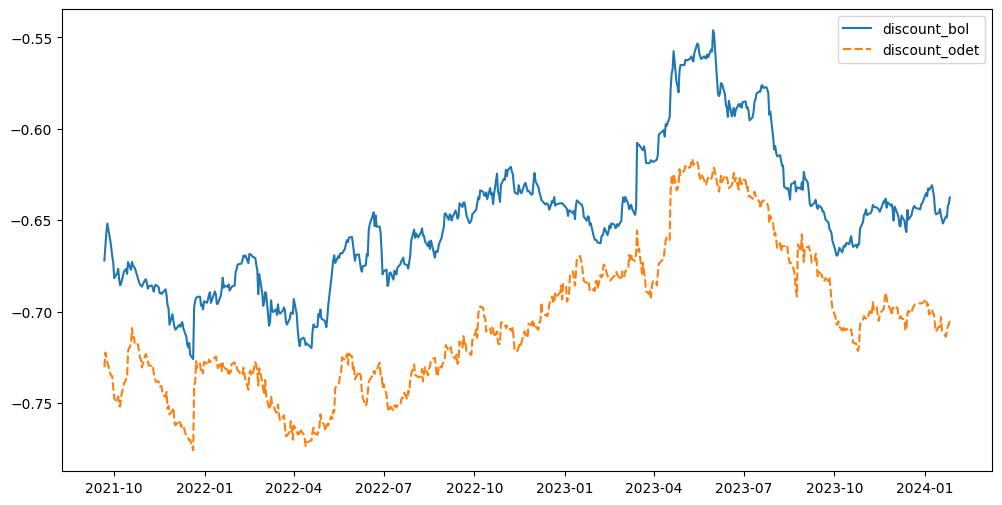

In [9]:
# Data visualisation, starting code - https://www.kaggle.com/code/alexisbcook/hello-seaborn
# Set the width and height of the figure
plt.figure(figsize=(12,6))

# Line chart showing how FIFA rankings evolved over time 
sns.lineplot(data=main_df[["discount_bol", "discount_odet"]])

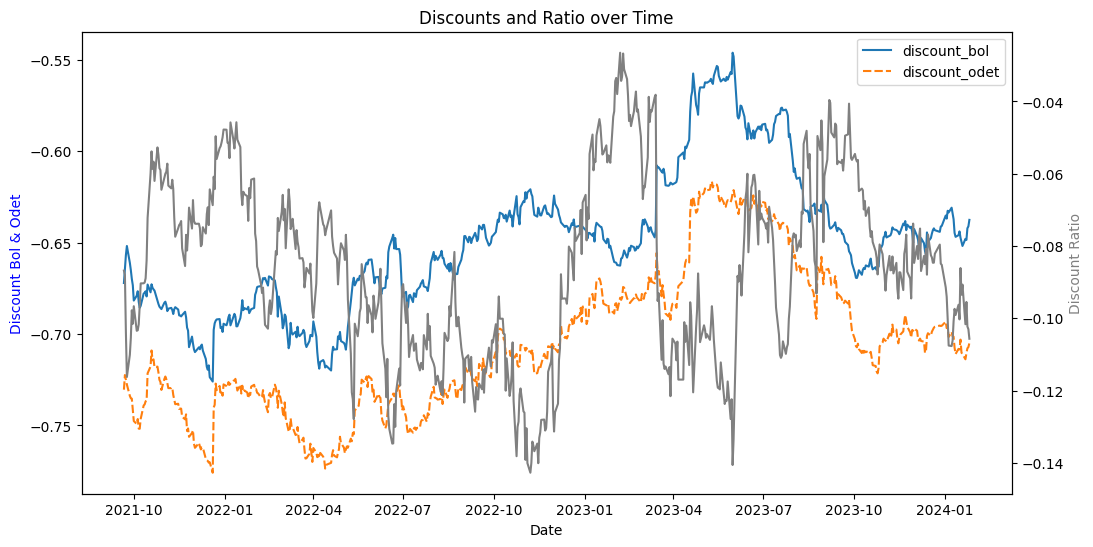

discount range: -0.026512152660705945 -0.1427052537940945
median & mean: -0.08607920233698407 -0.08655993325871351 standard deviation 0.02494277873314393


In [10]:
columns_to_plot = ["discount_bol", "discount_odet", "discount_ratio"]

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=main_df[columns_to_plot[:2]], ax=ax1)

ax2 = ax1.twinx()

sns.lineplot(data=main_df[columns_to_plot[2]], ax=ax2, color='grey')

ax1.set_xlabel('Date')
ax1.set_ylabel('Discount Bol & Odet', color='blue')
ax2.set_ylabel('Discount Ratio', color='grey')
plt.title('Discounts and Ratio over Time')

plt.show()

print("discount range:",main_df["discount_ratio"].max(), main_df["discount_ratio"].min())
print("median & mean:", main_df["discount_ratio"].median(), main_df["discount_ratio"].mean(),"standard deviation", main_df["discount_ratio"].std())

In [11]:
# generalised function for approach used below
def remove_columns_starting_with(start_df, prefixes_to_remove):
    columns_to_remove = [col for col in start_df.columns if any(col.startswith(prefix) for prefix in prefixes_to_remove)]
    return_df = start_df.drop(columns=columns_to_remove)
    return return_df

**Open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis**

In [12]:
# Feature engineering (feature selection)
# Removing all columns for open/high/low price for now (so we can focus on closing price)
columns_to_remove = [col for col in main_df.columns if any(col.startswith(prefix) for prefix in ('1. open', '2. high', '3. low', '5. volume'))]
# if col.startswith('1. open') or col.startswith('2. high') ... would have been alternate approach

end_day_df = main_df.drop(columns=columns_to_remove)
#NOTE - open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis

end_day_df.head()

,4. close_bol,4. close_odet,4. close_umg,4. close_viv,discount_odet,discount_bol,discount_ratio,price_ratio
2024-01-26,5.97,1474.0,27.75,10.210,-0.704942,-0.637586,-0.105641,0.969085
2024-01-25,5.90,1460.0,27.80,10.050,-0.707164,-0.641127,-0.103002,0.971270
2024-01-24,5.84,1446.0,27.47,9.972,-0.707839,-0.642173,-0.102257,0.971839
2024-01-23,5.70,1424.0,27.28,9.816,-0.710476,-0.648562,-0.095463,0.980560
2024-01-22,5.76,1420.0,27.75,9.836,-0.713829,-0.647977,-0.101627,0.967620


In [13]:
# Check Correlation Matrix:
correlation_matrix = end_day_df.corr() #main_df.corr()
correlation_matrix

#NOTE - open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis

,4. close_bol,4. close_odet,4. close_umg,4. close_viv,discount_odet,discount_bol,discount_ratio,price_ratio
4. close_bol,1.000000,0.908073,0.101458,-0.447376,0.861131,0.853862,-0.087979,0.413744
4. close_odet,0.908073,1.000000,0.184665,-0.404547,0.906211,0.737961,0.316891,0.756367
4. close_umg,0.101458,0.184665,1.000000,0.250988,-0.221614,-0.397654,0.472009,0.267179
4. close_viv,-0.447376,-0.404547,0.250988,1.000000,-0.617401,-0.676054,0.209276,-0.173065
discount_odet,0.861131,0.906211,-0.221614,-0.617401,1.000000,0.920287,0.083250,0.615580
discount_bol,0.853862,0.737961,-0.397654,-0.676054,0.920287,1.000000,-0.312814,0.259612
discount_ratio,-0.087979,0.316891,0.472009,0.209276,0.083250,-0.312814,1.000000,0.830278
price_ratio,0.413744,0.756367,0.267179,-0.173065,0.615580,0.259612,0.830278,1.000000


<Axes: >

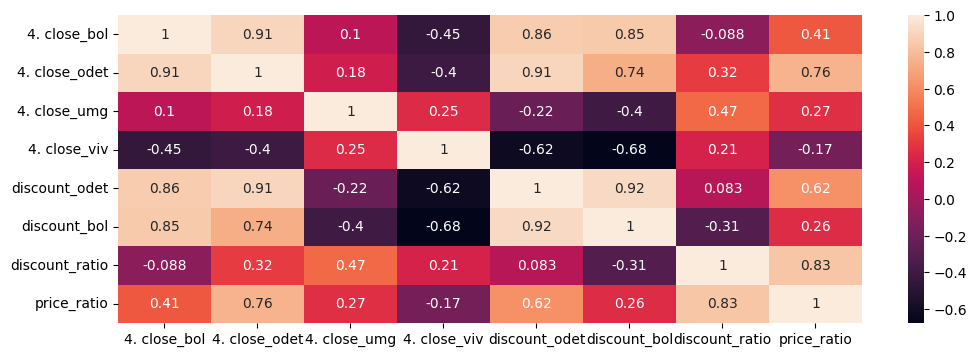

In [14]:
plt.figure(figsize=(12,4))
sns.heatmap(correlation_matrix, annot=True)

# Interesting observations
* Discount_ratio is most closely correlated with UMG stock price (surprising) & has limmited correlation with discount_odet (surprising).
* Otherwise discount_ratio shows some correlation with ODET price (not much with BOL), and some with discount_bol (but not much with discount_odet)
* Volumes don't seem to be closely correlated with anything significant & mostly correlate with one another.

In [15]:
# Target variable - goal is to figure out whether available information can provide good signals for trading the ODET / BOL pair.
# As a first attempt at a target variable I'm going to propose fractional profit/loss from buying ODET & selling BOL & holding for 60 days

# Shift the values of the desired column 60 days ahead
days_ahead = 120

dummy_df = pd.DataFrame()
dummy_df[f'price_{days_ahead}_days_ahead' + '_odet'] = main_df[time_price + "_odet"].shift(+ days_ahead)
dummy_df[f'price_{days_ahead}_days_ahead' + '_bol'] = main_df[time_price + "_bol"].shift(+ days_ahead)

# Calculates the fractional profit, from buying Odet and shorting Bollore for 60 days
main_df[f'trading_profit_{days_ahead}_days_frctn'] = (
    (main_df[time_price + "_odet"] - dummy_df[f'price_{days_ahead}_days_ahead' + '_odet'])
    / main_df[time_price + "_odet"]
    ) - (
    (main_df[time_price + "_bol"] - dummy_df[f'price_{days_ahead}_days_ahead' + '_bol'])
    / main_df[time_price + "_bol"]
    )

# number of rows=days_ahead of NaN need to be dropped for data to be useful for machine learning later (data wrangling)
main_df = main_df.dropna()

print(main_df.head())

            1. open_bol  2. high_bol  3. low_bol  4. close_bol  5. volume_bol  \
2023-08-08        5.625        5.630       5.600         5.610         760436   
2023-08-07        5.670        5.675       5.620         5.640         568434   
2023-08-04        5.660        5.685       5.620         5.665         778725   
2023-08-03        5.655        5.695       5.615         5.650         739520   
2023-08-02        5.660        5.750       5.620         5.690         999584   

            1. open_odet  2. high_odet  3. low_odet  4. close_odet  \
2023-08-08        1490.0        1494.0       1474.0         1480.0   
2023-08-07        1490.0        1502.0       1490.0         1496.0   
2023-08-04        1504.0        1510.0       1494.0         1494.0   
2023-08-03        1516.0        1518.0       1502.0         1504.0   
2023-08-02        1512.0        1520.0       1506.0         1516.0   

            5. volume_odet  ...  1. open_viv  2. high_viv  3. low_viv  \
2023-08-08         

In [16]:
# PCA:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

# 1st select and standardise data:

X = main_df.copy().drop(columns=columns_to_remove) #removes 'wrong' time of day
# X = remove_columns_starting_with(start_df=X, prefixes_to_remove=("5. volume"))

y = X.pop(f'trading_profit_{days_ahead}_days_frctn')

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [17]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)


In [18]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
4. close_bol,0.439712,0.039178,-0.444327,0.137373,-0.169634,-0.506799,0.524113,0.168836
4. close_odet,0.433332,0.245224,-0.154413,0.095952,-0.016497,-0.293867,-0.783409,-0.136670
4. close_umg,-0.146969,0.457580,-0.649943,-0.484051,0.063443,0.327162,0.012420,-0.032792
4. close_viv,-0.317510,0.313461,-0.240524,0.842323,0.041894,0.176475,0.010151,-0.023854
discount_odet,0.473346,0.030107,0.081781,0.096922,-0.133730,0.568963,-0.055888,0.643606
discount_bol,0.451603,-0.190942,-0.067112,0.111657,-0.071671,0.437009,0.179618,-0.717112
discount_ratio,-0.022676,0.591317,0.406017,-0.077731,-0.662085,-0.036842,0.135900,-0.144069
price_ratio,0.260668,0.493631,0.349873,-0.014361,0.709785,-0.050652,0.239716,-0.044023


<Axes: >

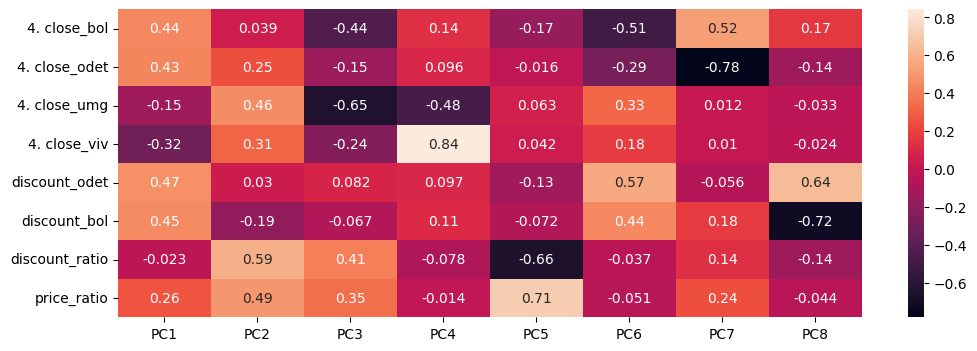

In [19]:
plt.figure(figsize=(12,4))
sns.heatmap(loadings, annot=True)

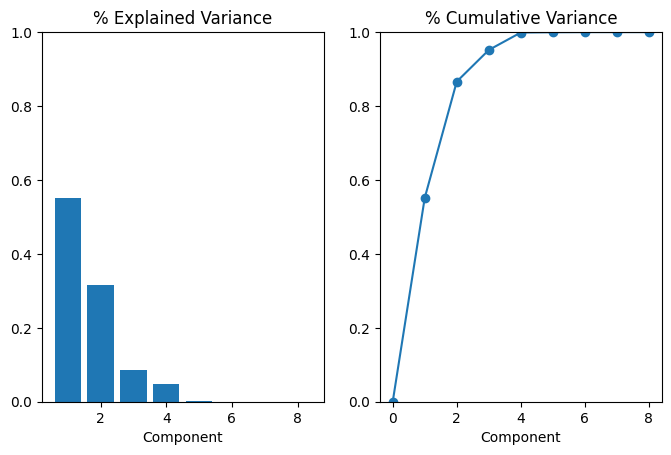

In [20]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
# Look at explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

# Initial attempts at random forest to explore which variables are important for predicting whether trades profitable/unprofitable
example code source = https://www.kaggle.com/code/alexisbcook/machine-learning-competitions/tutorial

In [21]:
##### Import helpful libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split # Not appropriate for this temporal dataset

# Need to split as timeseries:
from sklearn.model_selection import TimeSeriesSplit

# Separate the target
# I've already defined X and y for the PCA model, will use those for now.

#choose whether to include synthetic features related to price & discount
remove_features = False
if (remove_features):
    X = remove_columns_starting_with(X, ("price", "discount")) # test model without synthetic features

# new synthetic features:
add_upper_lower_thresholds = True
if (add_upper_lower_thresholds):
#     threshold_upper = X["discount_ratio"].median() - X["discount_ratio"].std()
#     threshold_lower = X["discount_ratio"].median() + X["discount_ratio"].std()
    threshold_upper = -0.11
    threshold_lower = -0.06


    X['discount_wide'] = np.where(X['discount_ratio'] < threshold_upper, 1, 0)
    X['discount_narrow'] = np.where(X['discount_ratio'] > threshold_lower, 1, 0)


# Doesn't appear to help the model - set to False
add_thresholds_price_ratio = False
if (add_thresholds_price_ratio):
    price_ratio_upper = 1.05
    price_ratio_lower = 0.95
    
    X['price_ratio_high'] = np.where(X['price_ratio'] > price_ratio_upper, 1, 0)
    X['price_ratio_low'] = np.where(X['price_ratio'] < price_ratio_lower, 1, 0)
    
    
# Instead:
# Create TimeSeriesSplit object - n_splits: number "folds"
tscv = TimeSeriesSplit(n_splits=10)

# Iterate over the splits
for train_index, val_index in tscv.split(X):
    train_X, val_X = X.iloc[train_index], X.iloc[val_index]
    
for train_index, val_index in tscv.split(y):
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
# .fit model initially returned error - input y contained NaN (before I ran main_df.dropna() )
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print(f'Validation MAE for Random Forest Model (%): {(rf_val_mae * 100).round(3)}')
print("Average absolute change (trading) in validation set",(val_y.abs().mean() * 100).round(3), "%")

print(val_X.head())
print(X["discount_narrow"].sum())

Validation MAE for Random Forest Model (%): 2.268
Average absolute change (trading) in validation set 4.615 %
            4. close_bol  4. close_odet  4. close_umg  4. close_viv  \
2021-11-19         4.942         1230.0         25.03        11.050   
2021-11-18         4.964         1260.0         25.38        11.070   
2021-11-17         5.050         1280.0         26.21        11.095   
2021-11-16         5.055         1280.0         26.25        11.105   
2021-11-15         5.170         1310.0         26.75        11.285   

            discount_odet  discount_bol  discount_ratio  price_ratio  \
2021-11-19      -0.745271     -0.689658       -0.080639     0.976880   
2021-11-18      -0.740828     -0.690383       -0.073068     0.996272   
2021-11-17      -0.740776     -0.689862       -0.073804     0.994850   
2021-11-16      -0.741010     -0.689834       -0.074186     0.993866   
2021-11-15      -0.738155     -0.686613       -0.075067     0.994534   

            discount_wide  dis

* **Temporal data, with consecutive time points highly likely to be correlated. A simple random split using train_test_split doesn't appear to be suitable.**
* **Swapping trading time perdiod from 60 -> 120 days seems to reduce MAE consdierably**

**For trading time = 120 days, with just stock prices (no synthetic variables), TimeSeriesSplit(n_splits=10)**
* Validation MAE for Random Forest Model (%): 3.577 --- (3.445% with volumes)
* Average absolute change (trading) in validation set 4.615 %

**Adding synthetic variable: "price_ratio"**
* Validation MAE for Random Forest Model (%): 2.699
* Average absolute change (trading) in validation set 4.615 %

**Adding only synthetic variables: "discount_odet", "discount_bol", "discount_ratio" (NOT "price_ratio)**
* Validation MAE for Random Forest Model (%): 2.718
* Average absolute change (trading) in validation set 4.615 %

**Adding synthetic variables: "discount_odet", "discount_bol", "discount_ratio", "price_ratio"**
* Validation MAE for Random Forest Model (%): 2.357
* Average absolute change (trading) in validation set 4.615 %

**Adding further synthetic variables (derived from discount ratio): "discount_wide", "discount_narrow"**
* Validation MAE for Random Forest Model (%): 2.268 --- (2.272% with volumes)
* Average absolute change (trading) in validation set 4.615 %

**Adding further synthetic variables (derived from price ratio): "price_ratio_high", "price_ratio_low"**
* Validation MAE for Random Forest Model (%): 2.422     //-> significantly worse
* Average absolute change (trading) in validation set 4.615 %

*overall, volumes don't appear to make much difference either way, so have chosen to remove for improved interpretability*


**Next step, use TensorFlow and Keras for machine learning & trinary classification (buy / hold / short, 1/0/-1)**

In [22]:
print("trading profit, max:",y.max(),"mean:", y.mean(),"std:", y.std())
print("------------------------")
dummy_df_2=pd.concat([X, y],axis=1)

def average_profit(discount_description, value, df=dummy_df_2):
    df = df[df["discount_" + discount_description] == value]
    return df["trading_profit_120_days_frctn"].mean()
    
print(average_profit("wide", 1), average_profit("narrow", 1))
print(average_profit("wide", 0), average_profit("narrow", 0))

trading profit, max: 0.15444098050003066 mean: -0.012720665892672027 std: 0.08348221588442996
------------------------
-0.10008241860131312 0.06584030229760993
0.01696302356357895 -0.027091574707967508
